In [ ]:
# 라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import multivariate_normal

In [ ]:
# 데이터 셋({x_n, y_n, type_n}) 만드는 함수(prepare_dataset) 선언하기
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋

def prepare_dataset(variance):
    # 파라미터 설정하기
    N1 = 20 # t=+1인 데이터 개수
    Mu1 = [15,10] # t=+1인 데이터 중심 (x,y) 좌표
    
    N2 = 30 # t=-1인 데이터 개수
    Mu2 = [0,0] # t=-1인 데이터 중심 (x,y) 좌표

    # 공분산 행렬 C = [[Var(X),Cov(X,Y)], [Cov(Y,X),Var(Y)]
    # Var(X): X축 분산, Var(Y): Y축 분산
    # Cov(X,Y) = 0, Cov(Y,X) = 0인 공분산. 두 변수 X, Y는 서로 독립적. 
    # 공분산이 0이고 X축, Y축 분산이 같음
    cov1 = np.array([[variance,0],[0,variance]])
    cov2 = np.array([[variance,0],[0,variance]])

    # t=+1인 데이터 생성
    df1 = pd.DataFrame(multivariate_normal(Mu1,cov1,N1),columns=['x','y'])
    df1['t'] = 1
    # t=-1인 데이터 생성
    df2 = pd.DataFrame(multivariate_normal(Mu2,cov2,N2),columns=['x','y'])
    df2['t'] = -1 
    
    # 생성된 데이터 합치기
    df = pd.concat([df1,df2],ignore_index=True)

    # df에 index를 랜덤으로 섞기
    df = df.reindex(np.random.permutation(df.index))
    
    # df에 index를 처음부터 다시 라벨링하기 
    # drop = True는 새로운 index를 추가로 만들지 않게 하기 위해서
    df = df.reset_index(drop=True)
    
    return df

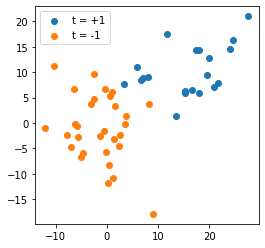

In [ ]:
# 트레인 셋 만들어 보기
Variance = 50

df = prepare_dataset(Variance)
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(df[df["t"]==1].x, df[df["t"]==1].y, label="t = +1")
ax.scatter(df[df["t"]==-1].x,df[df["t"]==-1].y, label="t = -1")
ax.legend()

In [ ]:
# 확률적 기울기 하강법을 함수화 한 과정
# 인풋: 트레이닝 셋, 이터레이션 횟수
# 아웃풋: results(w0, w1, w2, c, err_rate), paramhist

def calc_parameters(training_set, iteration_num, bias=None):
    # w 초기값 설정하기
    w0 = w1 = w2 = 0.0

    # c는 bias항
    if bias is None:
        c = 0.5 * (training_set.x.mean() + training_set.y.mean())
    else:
        c = bias

    # 확률적 기울기 하강
    # paramhist: parameter history
    paramhist = pd.DataFrame([[w0,w1,w2]], columns=['w0','w1','w2'])
    for i in range(iteration_num):
        for _, point in training_set.iterrows():
            x, y, t = point.x, point.y, point.t
            # w_new = w_old + t_n * phi_n
            if t * (w0*c + w1*x + w2*y) <= 0: # 잘못 분류된 트레이팅 셋 데이터만 대상
                w0 += t * c 
                w1 += t * x
                w2 += t * y
            # if t * (w0*1 + w1*x + w2*y) <= 0: # 잘못 분류된 트레이팅 셋 데이터만 대상
            #     w0 += c* t * 4.9 
            #     w1 += c * t * x
            #     w2 += c * t * y

        paramhist = paramhist.append(
                        pd.Series([w0,w1,w2], ['w0','w1','w2']),
                        ignore_index=True)
   
    # 잘못 분류된 데이터 비율(%) 계산하기
    # err: 잘못된 데이터 개수
    err_num = 0
    for _, point in training_set.iterrows():
        x, y, t = point.x, point.y, point.t
        if t * (w0*c + w1*x + w2*y) <= 0:
            err_num += 1
    err_rate = err_num / len(training_set) * 100

    result = {
        "w0": w0,
        "w1": w1,
        "w2": w2,
        "err_rate": err_rate,
        "bias": c
    }

    return result, paramhist

In [ ]:
# 트레이닝 셋 및 직선 시각화
def plot_data_graph_with_line(training_set, parameters, data_graph): 
    w0 = parameters["w0"]
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    bias = parameters["bias"]
    err_rate = parameters["err_rate"]
    
    # t가 1인 데이터셋
    training_set1 = training_set[training_set['t']==1]
    # t가 -1인 데이터셋
    training_set2 = training_set[training_set['t']==-1]

    # plot에서 x,y좌표 최소값 최대값 정하기
    ymin, ymax = training_set.y.min()-5, training_set.y.max()+10
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10    
    data_graph.set_ylim([ymin-1, ymax+1])
    data_graph.set_xlim([xmin-1, xmax+1])

    # 트레인셋 데이터 그리기
    data_graph.scatter(training_set1.x, training_set1.y, marker='o')
    data_graph.scatter(training_set2.x, training_set2.y, marker='x')

    # 직선 시각화
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - bias * w0 / w2
    label = "ERR %.2f%%" % err_rate
    data_graph.plot(linex,liney,label=label,color='red')
    data_graph.legend(loc=1) # loc = 1 : 우측 상단에 범례 표시

# 파라미터 변화 시각화
def plot_parameter_history(paramhist,param_graph):
    paramhist.plot(ax=param_graph)
    param_graph.legend(loc=1)

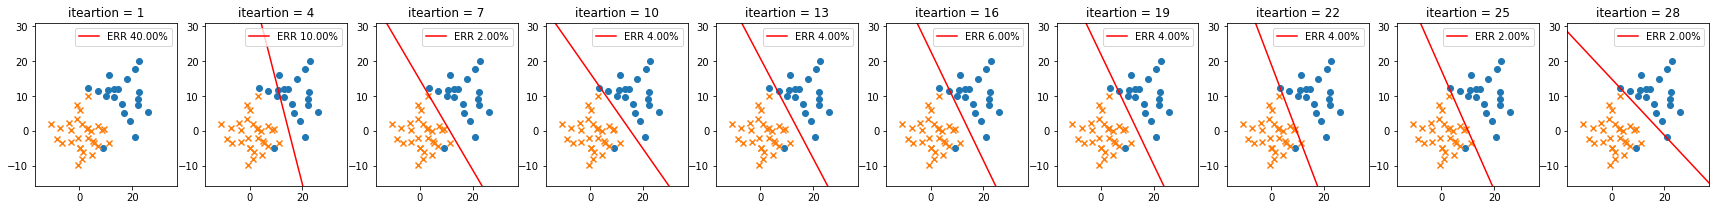

In [ ]:
# 이터레이션에 따른 결과 직선 계수(w0, w1, w2)의 변화 시각화

# 파라미터
max_num_of_iteration = 30
variance = 30

fig, axs = plt.subplots(1, 10, figsize=(30,3))
training_set = prepare_dataset(variance)

for itr in range(max_num_of_iteration): 
    if itr % 3 == 0:
        parameters, paramhist = calc_parameters(training_set, itr+1)
        plot_data_graph_with_line(training_set, parameters, axs[int(itr/3)])
        axs[int(itr/3)].set_title("iteartion = %d" % (itr+1))
fig.show()

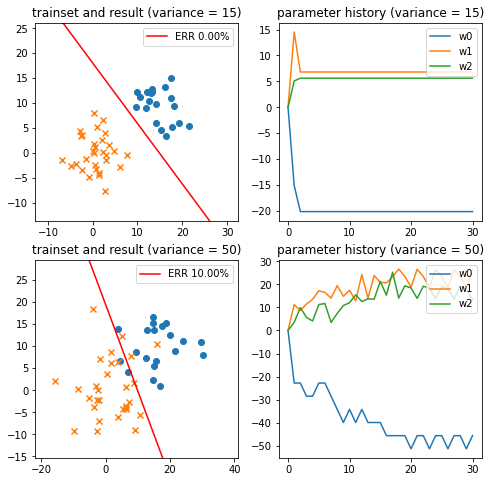

In [ ]:
# 서로 다른 variance값을 가진 트레인 셋에서의 결과를 시각화하여 비교하기

Variances = [15,50] # 분산 정도가 다른 두 데이터를 정의하기 위한 분산 리스트
iteration_num = 30

fig, axs = plt.subplots(2, 2, figsize=(8,8)) # width가 8inch 이고 height가 8inch 
for c, variance in enumerate(Variances):
    axs[c][0].set_title("trainset and result (variance = %d)" % variance)
    axs[c][1].set_title("parameter history (variance = %d)" % variance)
    training_set = prepare_dataset(variance)
    parameters, paramhist = calc_parameters(training_set, iteration_num)
    plot_data_graph_with_line(training_set, parameters,axs[c][0])
    plot_parameter_history(paramhist,axs[c][1])
fig.show()

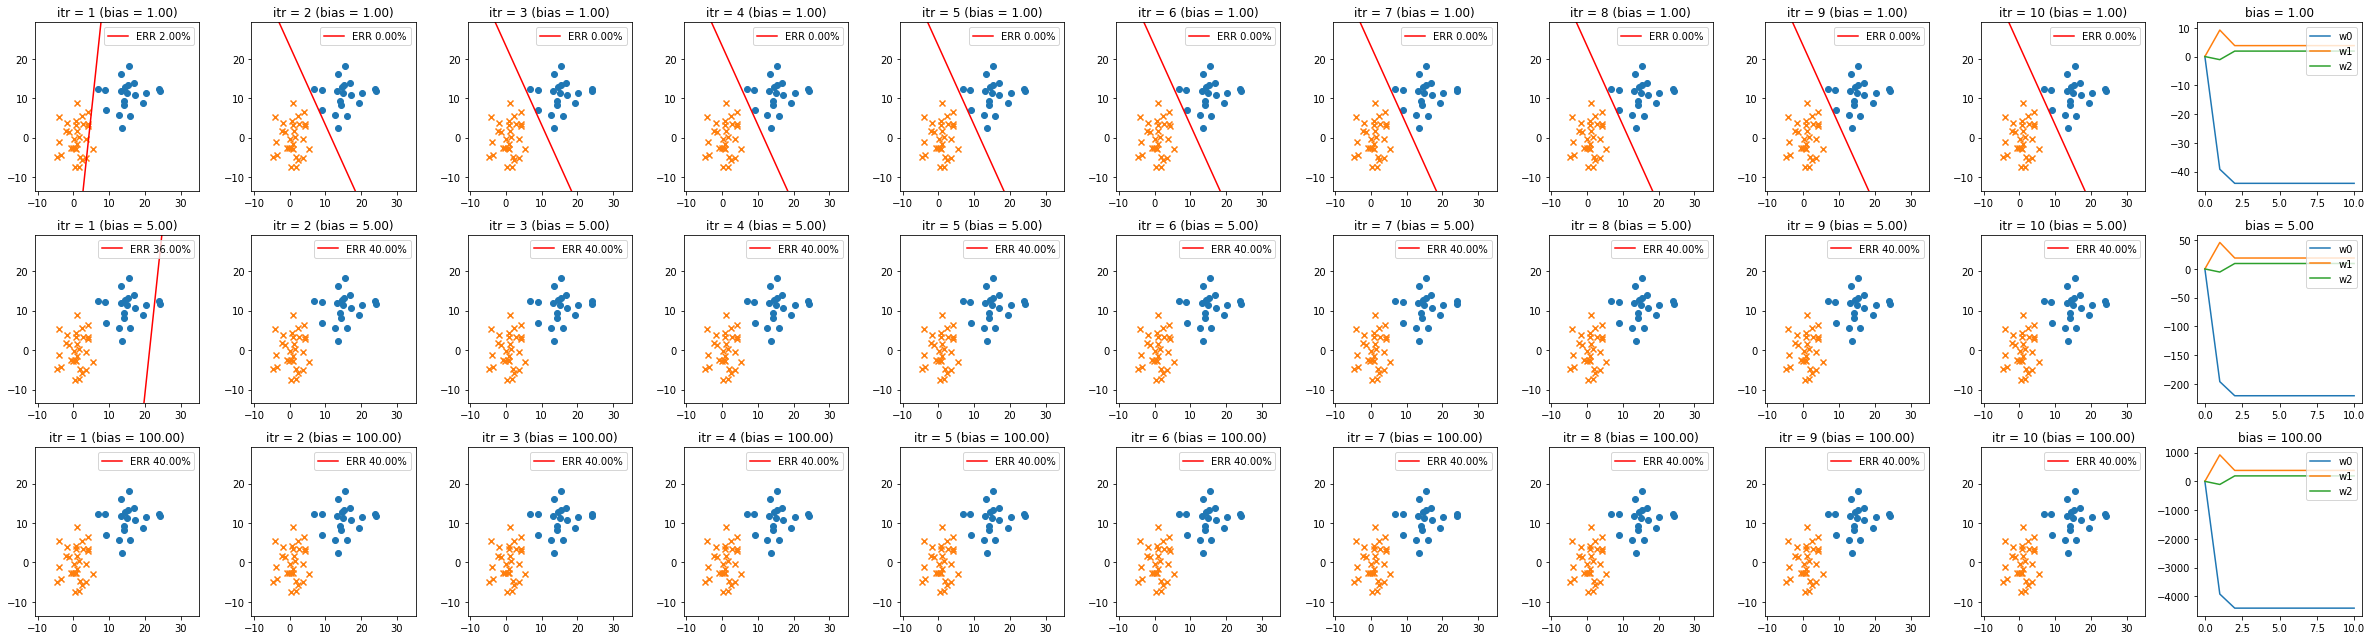

In [ ]:
# bias에 따른 결과 변화 시각화

# 파라미터
max_num_of_iteration = 10
#variance = 30
variance = 15
bias_list = [1, None, 10] # bias가 None인 경우 x_n, y_n의 평균

training_set = prepare_dataset(variance)

fig, axs = plt.subplots(3, 11, figsize=(33,9))

for row, bias in enumerate(bias_list):       
    for itr in range(max_num_of_iteration): 
        parameters, paramhist = calc_parameters(training_set, itr+1, bias=bias)
        if bias is None:
            _bias = parameters["bias"]
        else :
            _bias = bias 
        
        plot_data_graph_with_line(training_set, parameters, axs[row,itr])
        axs[row,itr].set_title("itr = %d (bias = %.2f)" % (itr+1,_bias))
    plot_parameter_history(paramhist,axs[row][10])
    axs[row][10].set_title("bias = %.2f" % (_bias))

fig.tight_layout()